In [3]:
import bom_water
from sidecar import Sidecar
from ipyleaflet import Map, GeoJSON, Polygon
from IPython.display import display, clear_output, HTML, JSON
import shapely
import json
import requests

In [4]:
'''Setup some constants'''
bm = bom_water.BomWater()
procedure = bm.procedures.Pat4_C_B_1_DailyMean
prop = bm.properties.Water_Course_Discharge

### Bounding Box for the MDB

In [6]:
low_left_lat = -37.505032
low_left_long = 138.00
upper_right_lat = -24.00
upper_right_long = 154.00

lower_left_coords = f'{low_left_lat} {low_left_long}'
upper_right_coords = f'{upper_right_lat} {upper_right_long}'

## Get Feature of interest for the MDB for:
- Property - Water Course Discharge
- Procedure - Pat4_C_B_1_DailyMean

Note - the BOM api is unable to filter base on a polygon, so a bounding box is used to obtain all point and then the Geofabric geometery is used to filter the results

In [7]:

# request( action, feature=None, prop=None, proced=None, begin=None, end=None, lower_corner=None, upper_corner=None)

response = bm.request(bm.actions.GetFeatureOfInterest, None, prop, procedure, None, None, lower_left_coords, upper_right_coords  )
response_json = bm.xml_to_json(response.text)
'''bomwater creates a FeatureCollection which can be used for mapping'''
feature_list = bm.create_feature_list(response_json, None )

bbox_poly = Polygon(
        locations=[(low_left_lat, low_left_long),(low_left_lat, upper_right_long),(upper_right_lat, upper_right_long),(upper_right_lat, low_left_long)],
    color="green",
    fill_color="green"
        )
m = Map(center=(-32, 146), zoom=5)

geojsonMarkerOptions = {
    'radius': 8,
    'fillColor': "#ff7800",
    'color': "#000",
    'weight': 1,
    'opacity': 1,
    'fillOpacity': 0.8
};

geo_json_stations = GeoJSON(
    data=feature_list,
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.8, 'fillColor': 'green', 'weight': 2})

loci_mdb = "https://gds.loci.cat/geometry/geofabric2_1_1_awradrainagedivision/9400206?_format=application/json&_view=simplifiedgeom"
def random_color(feature):
    return {
        'color': 'black',
        'fillColor': 'green',#random.choice(['red', 'yellow', 'green', 'orange']),
    }
mdb = json.loads(requests.get(loci_mdb).text)
geo_json_mdb = GeoJSON(
    data=mdb,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'green', 'dashArray': '0', 'fillOpacity': 0.3
    },
    style_callback=random_color
)

m.add_layer(geo_json_mdb)
m.add_layer(bbox_poly)
m.add_layer(geo_json_stations)

sc = Sidecar(title='MDB sites')
with sc:
    display(m)

'''Display the json response'''
JSON(response_json)

<IPython.core.display.JSON object>

## Filter results from using a bbox using a Geofabric geometry of the MDB

In [ ]:
mdb_sites = []
loci_mdb = "https://gds.loci.cat/geometry/geofabric2_1_1_awradrainagedivision/9400206?_format=application/json&_view=simplifiedgeom"
mdb = json.loads(requests.get(loci_mdb).text)
mdb_coords = mdb['coordinates']
poly_mdb = shapely.geometry.Polygon(mdb_coords[2][0])#mdb_coords is a multipolgon, so the 2nd index has the main poly of interest
display(poly_mdb)
for f in feature_list['features']:
    point = shapely.geometry.Point(f['geometry']['coordinates'])
    
    if point.within(poly_mdb):
#         print(f'Points X: {point.x}, Point Y: {point.y}')
        mdb_sites.append(f)
mdb_sites   

In [12]:
'''Quick look at the results'''
display(mdb_sites[0])
print(f'Found - {len(mdb_sites)} sites within the MDB')

{"geometry": {"coordinates": [148.818667, -35.481944], "type": "Point"}, "properties": {"long_name": "http://bom.gov.au/waterdata/services/stations/340000", "name": "Cotter_U/S_Stockyard", "stationId": null, "stationNo": "340000"}, "type": "Feature"}

Found - 1420 sites within the MDB


## Obtain one observations for display

,Value
Timestamp,
2003-08-20 14:00:00,NaN
2003-08-21 14:00:00,0.829
2003-08-22 14:00:00,0.896
2003-08-23 14:00:00,5.077
2003-08-24 14:00:00,5.712
...,...
2012-02-25 14:00:00,1.499
2012-02-26 14:00:00,1.673
2012-02-27 14:00:00,4.531


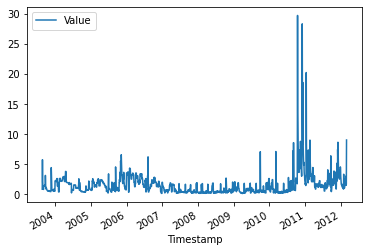

In [13]:
t_begin = "1800-01-01T00:00:00+10"
t_end = "2030-12-31T00:00:00+10"

try:
    response = bm.request(bm.actions.GetObservation, mdb_sites[0]['properties']['stationNo'], prop, procedure, t_begin, t_end)
except response.exceptions.RequestException as e:
    display(f'BoM service failed with RequestException: {e}')

response_json = bm.xml_to_json(response.text)  
ts = bm.parse_get_data(response)
ts.plot.line()
ts